Este dataset contiene registros clínicos de pacientes sospechosos y confirmados con COVID-19 en México. Las columnas indican características demográficas y médicas de cada paciente.

Columnas utilizadas:

USMER: Si fue atendido en una unidad monitora de enfermedades respiratorias.

MEDICAL_UNIT: Tipo de unidad médica que lo atendió.

SEX: Sexo del paciente.

PATIENT_TYPE: Si fue ambulatorio u hospitalizado.

INTUBED: Si fue intubado.

PNEUMONIA: Si presentó neumonía.

AGE: Edad del paciente.

PREGNANT: Si estaba embarazada (aplica a mujeres).

DIABETES, COPD, ASTHMA, INMSUPR, HIPERTENSION, OTHER_DISEASE, CARDIOVASCULAR, OBESITY, RENAL_CHRONIC, TOBACCO: Presencia de comorbilidades.

CLASIFFICATION_FINAL: Resultado de clasificación (confirmado, negativo, sospechoso).

ICU: Si fue ingresado a terapia intensiva.

(No se usa DATE_DIED porque no es útil para clustering sin preprocesar fechas.)

In [3]:
from google.colab import drive
import pandas as pd

# Montar Google Drive
drive.mount('/content/drive')

# Cargar el dataset COVID
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Covid Data.csv')

# Mostrar las primeras filas
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


Selecciona solo columnas numéricas o categóricas codificadas que se puedan usar en clustering.

Elimina registros con valores faltantes (dropna()).

Limita a 20,000 registros para que el procesamiento sea más rápido y manejable.

In [4]:
# Columnas relevantes (todas numéricas menos DATE_DIED que se omite aquí)
cols = [
    'USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
    'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
    'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
    'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'
]

# Eliminar nulos y limitar a máximo 20,000 filas
data = df[cols].dropna().iloc[:20000]


Normaliza todas las columnas a media 0 y desviación estándar 1.

Esto es importante porque K-means se basa en distancias: si una variable (por ejemplo, edad) tiene un rango mucho más alto que otras (como variables binarias), dominará el clustering.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


Método del Codo

Prueba diferentes valores de k (número de clusters).

Calcula la inercia, que representa la suma de distancias dentro de los clusters (error).

La gráfica muestra cómo disminuye el error al aumentar k. El punto donde empieza a aplanarse es el "codo", y es un buen candidato para el número ideal de clusters.

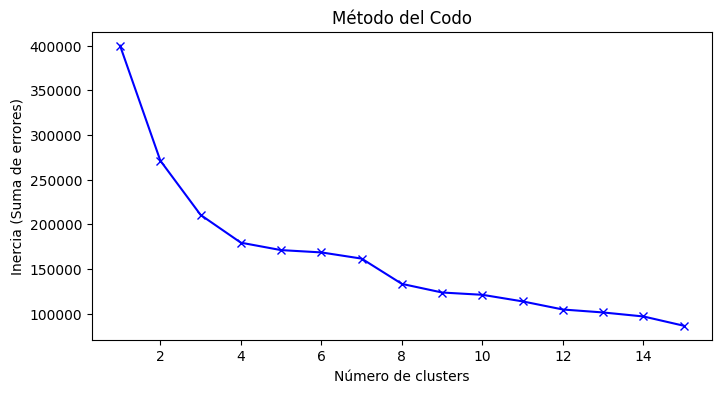

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 16)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia (Suma de errores)')
plt.title('Método del Codo')
plt.show()


Silhouette Score

Mide qué tan bien definidos están los clusters.

El Silhouette Score va de -1 a 1: mientras más cercano a 1, mejor separación entre grupos.

Se prueba para k entre 9 y 14 porque los valores bajos daban scores muy bajos (< 0.3).

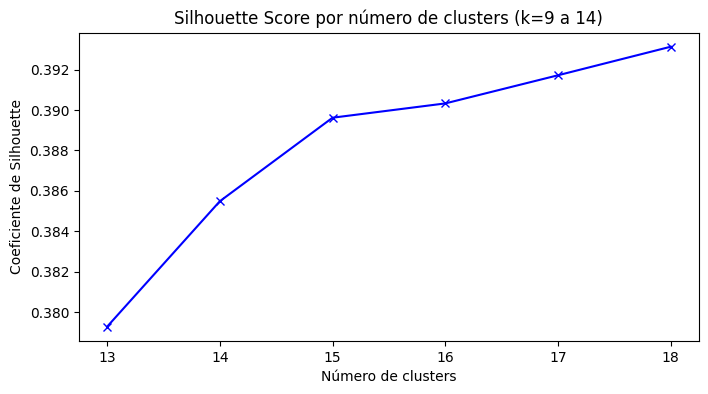

In [13]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
kmeans_per_k = {}

for k in range(13, 19):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, preds)
    silhouette_scores.append(score)

    kmeans_per_k[k] = {
        'model': kmeans,
        'labels': preds
    }

plt.figure(figsize=(8, 4))
plt.plot(range(13, 19), silhouette_scores, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Silhouette Score por número de clusters (k=9 a 14)')
plt.show()


Silhouette por cluster (detallado)

Para cada valor de k, calcula el score de cada paciente.

Muestra un gráfico horizontal donde se ve qué tan cerca o lejos están los puntos de su cluster vs. otros.

Es útil para ver si hay clusters superpuestos o si algunos son mucho mejores que otros.



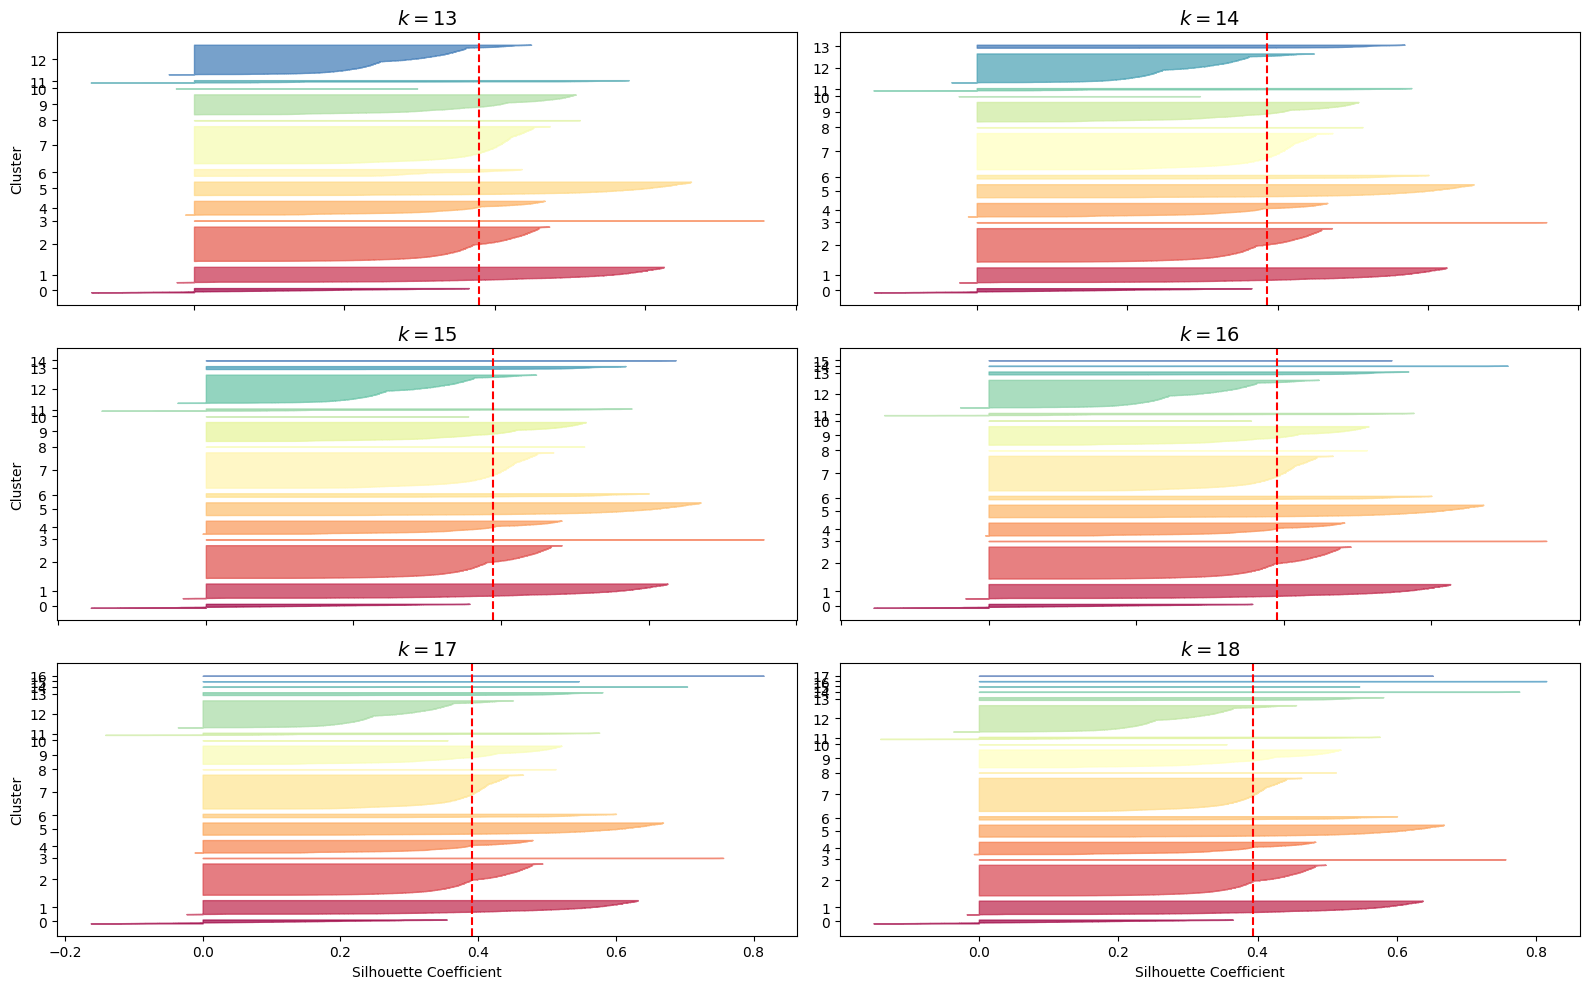

In [14]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
import numpy as np

silhouette_scores_subset = []
for k in range(13, 19):
    y_pred = kmeans_per_k[k]['labels']
    score = silhouette_score(data_scaled, y_pred)
    silhouette_scores_subset.append(score)

plt.figure(figsize=(16, 10))

for idx, k in enumerate(range(13, 19)):
    plt.subplot(3, 2, idx + 1)

    y_pred = kmeans_per_k[k]['labels']
    silhouette_vals = silhouette_samples(data_scaled, y_pred)

    padding = len(data_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_vals[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    if idx % 2 == 0:
        plt.ylabel("Cluster")
    if idx >= 4:
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores_subset[idx], color="red", linestyle="--")
    plt.title(f"$k={k}$", fontsize=14)

plt.tight_layout()
plt.show()


In [9]:
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Añadir etiquetas al DataFrame original
data['Cluster'] = clusters


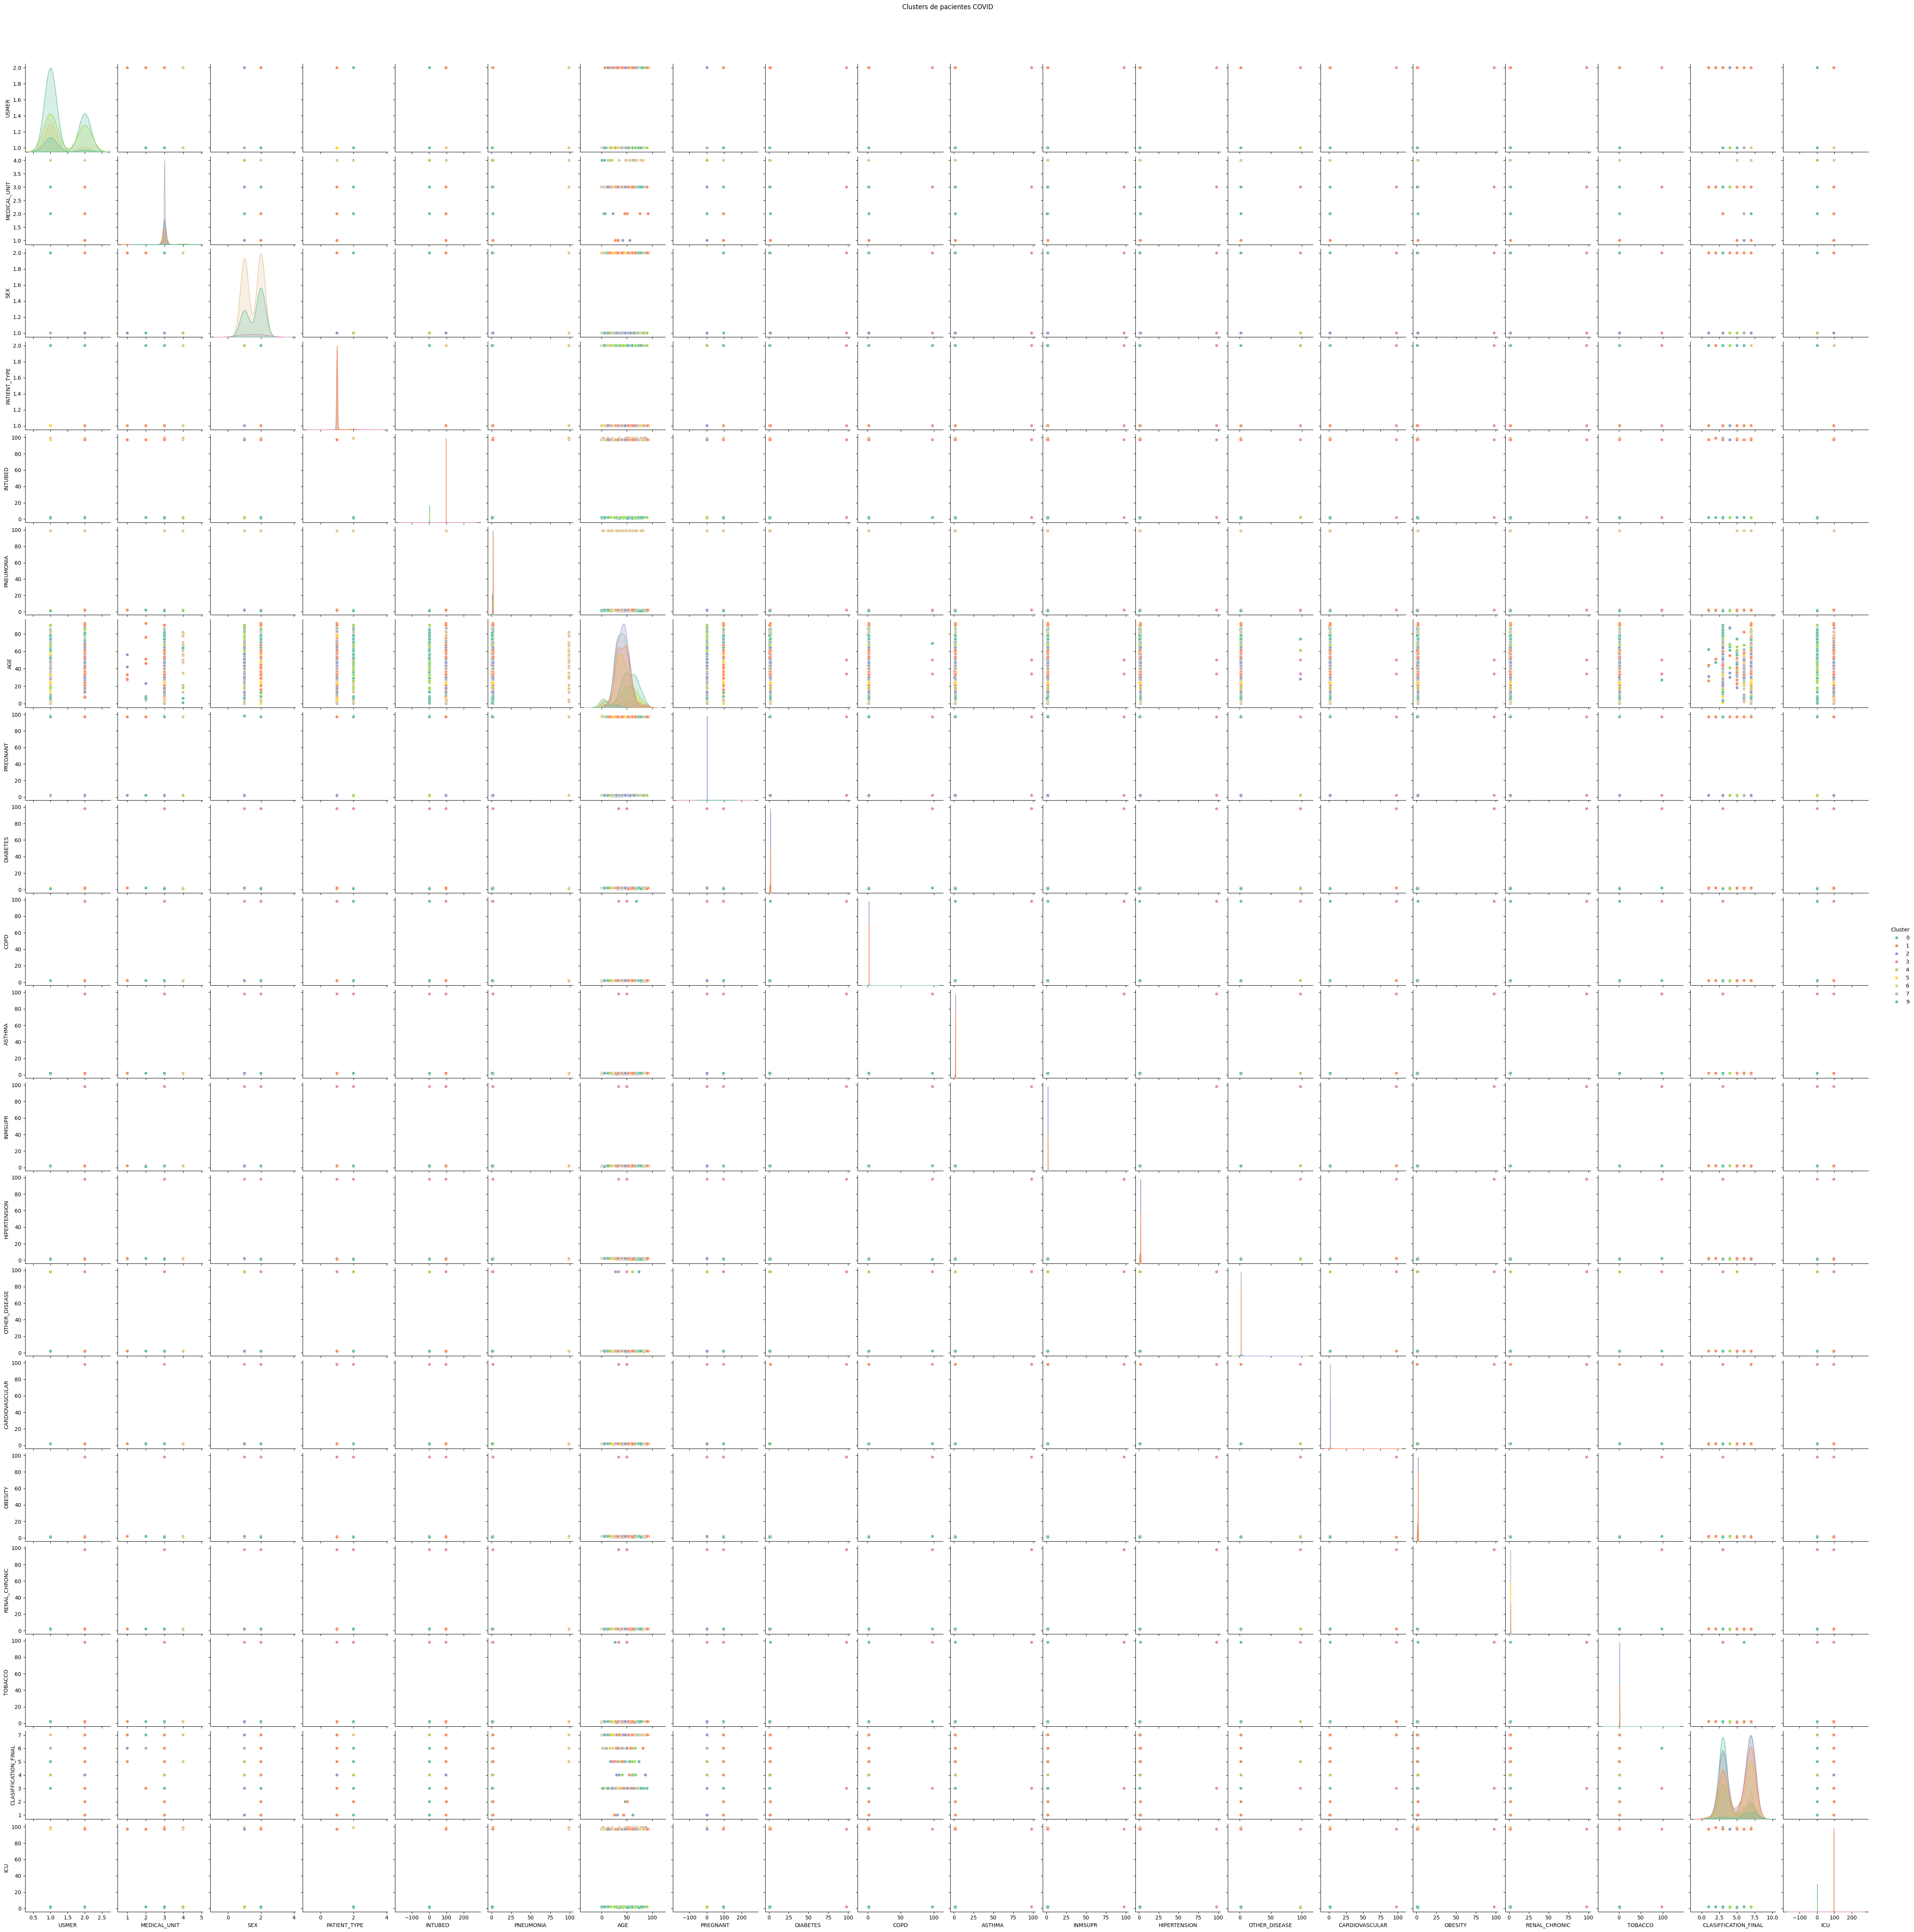

In [10]:
import seaborn as sns

sns.pairplot(data.sample(1000), hue='Cluster', palette='Set2')  # Muestra solo 1000 por claridad
plt.suptitle("Clusters de pacientes COVID", y=1.02)
plt.show()
